# WEEK 4 LAB: Functions in Python and HII Regions in M33


In this week's lab, we'll see how to construct and use Python functions in practice, using a narrowband image of the galaxy M33 as our dataset. 

Our ultimate goal will be to nicely plot and crop our image to make scientific measurements of the physical size of certain features in the galaxy. 

We'll also see at the end why writing functions was a useful way to organize and carry out this analysis. We'll start focusing just on the image. In Part II, there is a scientific overview regarding HII regions and why we are interested in them. 

Let's dive in!

In [ ]:
# Some libraries we'll need throughout
from astropy.io import fits 
from astropy.wcs import WCS 
import numpy as np 
import matplotlib.pyplot as plt

## Warm up 
Before we start making more involved functions to handle the datasets below, let's warm up with a few simple functions that will use some of the concepts we covered in the lecture. 

::::{admonition} Exercise 0.1
:class: tip
1. Write a function `minmax()` which accepts a list or array of values and returns an array containing the maximum and minimum values of the list. Add a keyword argument "positive" (bool; default False) which, if set to `True`, will return the min and max of the list *only for those values > 0*. If no values are greater than 0, it should return `array([None, None])`. 
2. Run your function on the lists `[-1,-2]`, `[-1,1,-2]`, and `[-34,10,15]` to check the outputs are as expected in all cases.

:::{hint}
:class:dropdown
What is the best way to check if the input is a list or array? A simple solution most of the time is to just work with arrays. We can coerce any input list to an array by running `np.array(list_name)`, and if the input was already an array, this operation will do nothing. 
:::
::::

In [65]:
# solution 0.1
from typing import Union 

def minmax(array: Union[list,np.ndarray],positive:bool=False)->list:
    """ 
    Return the minimum and maximum of an array, optionally using only positive values. 
    
    Parameters
    ----------
    array: Union[list, np.ndarray]
        input array of numbers 
    positive: bool, optional
        whether to only consider positively valued numbers, by default False
    
    Returns
    -------
    list
        list of [min,max] of the array. 
        If 'positive' is True and no values are positive, the return value will be [None,None]
    """
    array = np.array(array) #make sure we have an array
    if positive:
        pos = array[array>0] #index array using mask for positive values
        if not pos.size>0:  #check if our array has any values in it
            return [None,None]
        return [np.min(pos),np.max(pos)] #if at least 1 value is positive, we can safely run this
    return [np.min(array),np.max(array)] # if positive==False, we can just grab min/max or original array 


print(minmax([-1,-2],positive=True))
print(minmax([-1,1,-2],positive=True))
print(minmax([-34,10,15]))

[None, None]
[1, 1]
[-34, 15]


::::{admonition} Exercise 0.2 
:class: tip
1. Write a function `peak_finder()` which accepts a 1D list or array, confirms it is 1D, and then returns any peak positions, where a peak is defined as an index where the value of the array is higher than both the left hand and right hand values in the array. For example, in the list `[0,0,0,1,1,2,3,2,2,1,2,1,0]`, the output should be `[6,10]`, as those two positions in the list are the only ones for which the value is higher than both neighbors. 
2. Run your peak finder on the example list here and confirm the output.
:::{hint}
:class:dropdown

There are multiple solutions to this problem. For a nicely optimized (fast) solution that involves no loops, check out the function `scipy.ndimage.maximum_filter1d`. This function can be used to very effectively find peaks, if you're a bit clever! 
:::

::::

In [108]:
# solution 0.2

def peak_finder(array):
    """
    Find the peaks (values higher than neighbors) in an array 
    Parameters
    ----------
    array: Union[list,np.ndarray]
        array to find peaks in, must be 1D
    """
    array = np.array(array) #make sure lists become arrays
    if not array.ndim == 1:
        raise AssertionError('Array must be 1D')
    peaks = []
    for i in range(1,len(array)-1):
        if (array[i-1] < array[i]) and (array[i+1] < array[i]):
            peaks.append(i) 
    return peaks
        

# Solution using no loop 
from scipy.ndimage import maximum_filter1d 

def find_peaks(arr):
    gtl = arr[1:-1] > arr[:-2]
    gtr = arr[1:-1] > arr[2:]
    a = np.roll(gtl.astype(int),1).astype(bool)
    b = np.roll(gtr.astype(int),1).astype(bool)
    
    return 



    

In [67]:
peak_finder([0,0,0,1,1,2,3,2,2,1,2,1,0])

[6, 10]

In [105]:
arr = np.array([0,0,0,1,1,2,3,2,2,1,2,1,0]) 
gtl = arr[1:-1] > arr[:-2]
gtr = arr[1:-1] > arr[2:]
np.roll(gtl.astype(int),1).astype(bool)
np.roll(gtr.astype(int),1).astype(bool)

array([ True, False, False, False, False, False,  True, False,  True,
       False,  True])

In [96]:
np.roll(gtl.astype(int),1)

array([0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0])

In [98]:
np.roll(gtl.astype(int),1).astype(bool)

array([False, False, False,  True, False,  True,  True, False, False,
       False,  True])

In [109]:
find_peaks([0,0,0,1,1,2,3,2,2,1,2,1,0])

AttributeError: 'bool' object has no attribute 'astype'

When we wish to load a `fits` file into Python, this is the standard method, as we've already covered. Using the *context manager*, we open the file by passing a string with the file path, we can then grab the image (as a `numpy` array) and potentially the `wcs` if we need it (more on that below). Not every file will follow this format, but most will. 

In [57]:
with fits.open('./M33_halpha.fits') as hdu:
    im = hdu[0].data 
    wcs = WCS(hdu[0].header)

We can, if we wish, encapsulate this operation into a function. It's short enough that it's not *overly* onerous to write out each time. But we can make these three lines into one, which might make our code easier to read when loading many different `fits` files throughout a script. 

:::{tip} Exercise 1.1

1. Start by defining a function `load_fits` which has arguments `fname` (`str`), and `extension` (`int`). These are the pieces of information we needed above. 
2. Then add these lines above into the function trading out the hard coded elements for the function arguments. 
3. Finally, `return im, wcs`. As the majority of `fits` image store the image in the 0th extension, you can set the default for that argument to 0. 

:::{warning} Remember! 
Don't forget to document your function!
:::
:::

In [1]:
# solution 
def load_fits(fname:str,
              extension:int=0):
    """Load a fits file.

    Parameters
    ----------
    fname : str
        path to fits file to load
    extension : int, optional
        extension of the fits file with the image/header to load, by default 0
    """
    with fits.open(fname) as hdu:
        im = hdu[extension].data 
        wcs = WCS(hdu[extension].header)
    return im, wcs 

:::{tip} Exercise 1.2 

One danger of our function above is that some fits image do not have any `wcs` information stored in their header. At current, we will throw an exception if we try to load such an image. 

1. Add a `try/except` statement to your function around the `wcs=` line. Try loading a `wcs` as we did above, but if there is an exception, continue, and return the `im` (image pixels) and `None` for the `wcs` return. Optionally, print a message that this occurred.
:::

In [5]:
# solution 
def load_fits(fname:str,
              extension:int=0):
    """Load a fits file.

    Parameters
    ----------
    fname : str
        path to fits file to load
    extension : int, optional
        extension of the fits file with the image/header to load, by default 0
    """
    with fits.open(fname) as hdu:
        im = hdu[extension].data 
        try:
            wcs = WCS(hdu[extension].header)
            return im, wcs 
        except:
            print('WCS could not be loaded, will be None.')
            return im, None 
    

:::{admonition} Exercise 1.3 
:class: tip 
Use your new `load_fits` function to read in the `M33_halpha.fits` file. Save the output of the function into the variables `m33_im` and `m33_wcs`.
:::{tip}
:class:dropdown
If you get an error about `fits` or `WCS`, make sure you've *imported* those functions from astropy in your file!
:::
:::

In [8]:
# solution 
from astropy.io import fits 
from astropy.wcs import WCS 
m33_im, m33_wcs = load_fits('M33_halpha.fits')

:::{admonition} Exercise 2.1 
:class:tip 

Let's visualize the image we have loaded. 

1. Use the `imshow` command to plot the image. To see anything useful, you will need to set the `vmin` and `vmax` arguments --- a convenient choice is to compute the `np.percentile` of the data at `[1,99]` and to set those as the min and max scalings. 
2. Additionally set `origin='lower'` and `cmap='gray_r'` in your imshow call. 

I suggest a figure size of 10 by 10 inches.
:::


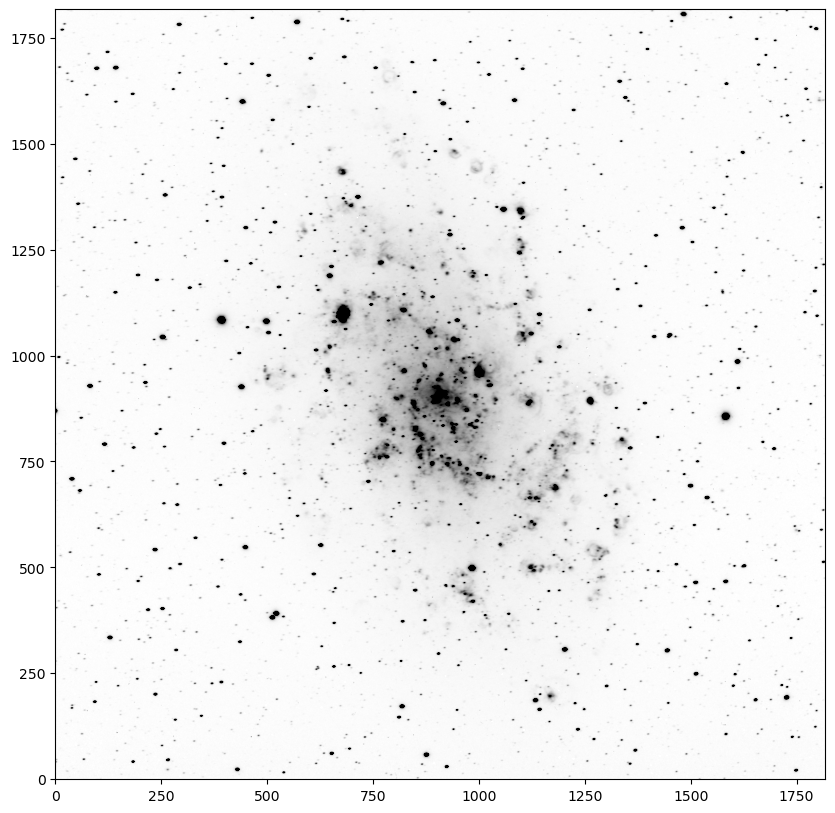

In [9]:
# Solution
import matplotlib.pyplot as plt 
import numpy as np 
fig, ax = plt.subplots(figsize=(10,10))
vmin,vmax = np.percentile(m33_im,[1,99.5])
ax.imshow(m33_im,origin='lower',vmin=vmin,vmax=vmax,cmap='gray_r')

:::{admonition} Exercise 2.2 
:class:tip 

This is already a few lines of code, and we *often* need to plot astronomical images. Let's now make a function that can streamline some of these lines of code above for us. 

First define a function `implot`. The first argument should be a variable `path_or_pixels`. We're going to allow users to either provide a file name to a `fits` file directly, or provide an image array (as we did above). To handle this, write some logic using the `isinstance()` python function to check whether the input is an array or a string, and if it is a string, use the `load_fits` function we wrote in Exercise 1 to load the image. (Otherwise, we'll just set our image to be the `path_or_pixels` input, assuming it is an array. You could use `isinstance()` again to check if it is a numpy array and raise an exception if not, optionally.)

Include as arguments the following: 
1. `percentiles` (`list`) (which will let users scale `vmin` and `vmax`, set to a default of `[1,99.5]`.
2. `figsize` (`tuple`): an optional argument with a default set to something like (8,8).
3. `cmap` (`str`): argument with a default of `'gray_r'`, passed along the `imshow` command, giving us control over the plotting color mapping. 

Your function should `return` the `fig` and `ax` objects it created. 

:::{admonition} _Hint: isinstance()_
:class: dropdown 

If you haven't used `isinstance()` yet, here's a primer. 

When we want to check the `type` of a variable, we can use `type(var_name)` to see its typename. When we want to check or ensure that a variable's type matches some desired type, we can use `isinstance(variable,type)` to return `True` or `False`. For example, `isinstance('test',str)` would return true, because the input `'test'` is a string. The names for the built-in types are `str`,`bool`,`list`,`dict`,`tuple`,`float`,`int`, etc. For a `numpy` array, its "type" is `np.ndarray`. 

:::


:::{admonition} Hint 
:class:note 
We haven't covered how to type-hint multiple allowed types yet. Here's a preview hint if you want to include it, but you don't have to: 
```python
from typing import Union 
def func(arg: Union[np.ndarray,list]):
    ...
```
:::
:::


In [20]:
# solution 
from typing import Union 

def implot(path_or_pixels:Union[str,np.ndarray],
           figsize:tuple=(10,10),
           cmap:str = 'gray_r',
           percentiles:list=[1,99.5]):
    
    if isinstance(path_or_pixels,str):
        im, wcs = load_fits(path_or_pixels) 
    elif isinstance(path_or_pixels,np.ndarray):
        im = path_or_pixels 
    else:
        raise AssertionError('input must be string or numpy array')
    fig, ax = plt.subplots(figsize=figsize)
    vmin,vmax = np.percentile(m33_im,percentiles)
    ax.imshow(im,origin='lower',vmin=vmin,vmax=vmax,cmap=cmap)
    return fig, ax

:::{admonition} Exercise 2.3
:class:tip 
Try out your function to make sure it is working as expected --- try inputting both our image array from above, as well as the file name. Try changing the percentiles and figsize and make sure the function responds accordingly. 
:::

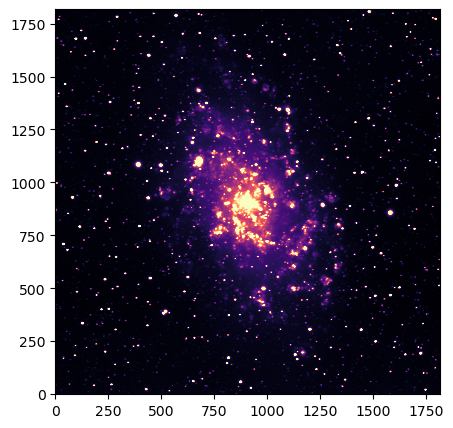

In [25]:
# Solution
fig, ax = implot('M33_halpha.fits',figsize=(5,5),percentiles=[1,99],cmap='magma')

````{admonition} Exercise 2.4 
:class:tip 

Now we want to incorporate the `wcs` into the mix. 


```{note}
A WCS object encapsulates the "world coordinate system", which indicates where on the sky an image is pointed. You can think of these coordinates like latitude and longitude on Earth, but for the full sky. We'll learn more about these objects later, but for now, know that a `wcs` object can be constructed from the `fits` file header (when the image has that information), and tells our plotting code how to map between a pixel position and a sky position under the hood.
```


Currently, a `wcs` will be accessible if the user provides the path to a file that has one. Now, add an optional argument to your function `wcs` with a default of `None`. Add logic so that if the `wcs` is not `None` (either from loading an image, or after the function input), we add the following to our subplots command:
```python
fig, ax = plt.subplots(figsize=figsize,subplot_kw={'projection':wcs})
```

What this does is turn our regular axis into a `WCSAxis`, which can handle plotting astronomical units along the axes of our image. 

Try your function again, but this time add the `wcs` we created in the previous exercise. How do your plot axes change?


```{admonition} Extra Feature (optional)
:class: dropdown

At the moment, the user *chooses* whether to provide a wcs for the pixels case, but we *force* a wcs plotting if a path to a fits file that contains a wcs is provided. This should be the default case, but it might be nice to give the option to turn that off. The easiest way to accomplish this is to add an `ignore_wcs` optional argument to your function which has a default of `False`. Thus, given an image file path, we can plot using coordinates by default, or the raw pixels by ignoring any wcs present. This works too if we provide a wcs but want to easily toggle it on and off.

```
````

In [26]:
# Solution 

def implot(path_or_pixels:Union[str,np.ndarray],
           figsize:tuple=(10,10),
           percentiles:list=[1,99.5],
           cmap:str = 'gray_r',
           wcs=None,
           ignore_wcs=False):
    if isinstance(path_or_pixels,str):
        im, wcs = load_fits(path_or_pixels) 
    elif isinstance(path_or_pixels,np.ndarray):
        im = path_or_pixels 
    else:
        raise AssertionError('input must be string or numpy array')
        
    if wcs is not None:
        if not ignore_wcs:
            fig, ax = plt.subplots(figsize=figsize,subplot_kw={'projection':wcs})
        else:
            fig, ax = plt.subplots(figsize=figsize)
    else:
        fig, ax = plt.subplots(figsize=figsize)
    vmin,vmax = np.percentile(m33_im,percentiles)
    ax.imshow(im,origin='lower',vmin=vmin,vmax=vmax,cmap=cmap)
    return fig, ax

:::{admonition} Exercise 2.5 
:class: tip 

Try out your function again, using both the fits file string and the array, but now try all your toggles --- i.e., fits file string, fits file string plus 'ignore_wcs' if you added that feature, array input, array input + wcs object input. Do you get the proper behavior? Below is an example of what the output should look like for default loading of the image.
:::

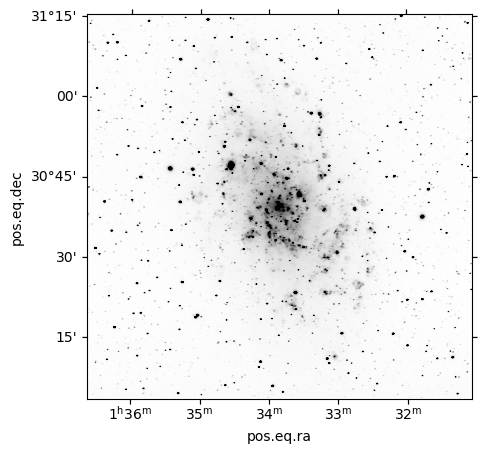

In [19]:
fig, ax = implot('M33_halpha.fits',figsize=(5,5))

There are now 13 lines of logic in our function, and hopefully it is becoming clear why making such a function is so useful --- we can now very quickly and easily load and plot any fits file, or any array we have on hand, with `wcs` on or off, with limits setting, all in one line. 

:::{note}
Notice that we `return` the `fig` and `ax` objects at the end of our function. This is useful because if we want to add to our plot (say, add a circle somewhere, or text), or *change* our plot (adjust the limits, etc.) we need to be able to access those objects. As we learned when we discussed **scope**, anything from inside a function that we want access to after the function has been run must be `returned` back to the larger scope of the python script we are working in.
:::


## Part II: The Size of HII Regions 

::::{admonition} _The Science_
:class:dropdown

For the rest of the assignment, we will be investigating the physical size of HII regions in nearby galaxy M33. Not sure what that means? Here's a quick primer. 

Stars form of many different masses (from much smaller than the sun to **much** larger), with many more low mass stars forming than massive stars$^*$. While very few high mass (e.g., 3-10+ $M_{\odot}$) stars form at a time in a galaxy, they have an outsized effect, dominating the light of the low mass stars (though they live much shorter lives). They are also the only stars (dubbed O-type) who put out significant light in the ultraviolet part of the spectrum. We know that our own sun does emit *some* light in the UV (that's the more high energy, dangerous light that can give us cancer, hence sunscreen), but these stars pump out *most* of their light in the UV. 

UV light has enough energy to *ionize* the atoms in gas (especially hydrogen gas), which means to knock the bound electron out of the atom and leave behind a proton and an electron. In some equilibrium, these electrons *recombine* with protons, and the electrons *cascade* through several energy levels as they fall toward the ground (most bound) state. For each gap they drop, the atom emits a photon with an equivalent energy to the difference between the levels traversed. 

This process of recombination produces light at specific wavelengths, so when you look at planetary nebulae, star forming regions, or supernova remnanta (see below), the colors are representitive of the different elements and energy levels being traversed. 

![eagle nebula](eagle.jpg)
_The Eagle Nebule, where we can see the hollow region being blown out by young stars (with the famous pillars of creation remaining, soon to be whittled down. Credit: ESO_

Bright, young stars actually put out enough radiation to "blow out" and push on the gas remaining from the clouds from which they formed. This carves our roughly spherical regions known as Strömgen spheres, the inner boundary of which is usually lit up in this ionized emission. The *size* of the sphere blown out depends on the total amount of flux coming from the bright stars, which in turn depends on how many of them there are. 

In our image of M33, we can see lots of these roughly spherical regions being highlighted by the narrow, H$\alpha$ filter being used to observe the galaxy. By measuring their size in pixels and using our knowledge of the distance to M33, we can perform some simple trigonometry to determine their actual physical sizes. As a bonus, we can then roughly estimate the number of O-type stars responsible for the visible HII region. (note that Starforming region and HII region are roughly synonymous; HII is the chemical name for ionized hydrogen). 


:::{admonition} \*
:class: dropdown 
Stars that form together out of one more massive cloud have masses drawn from what is called an initial mass function, or IMF, which is roughly exponential.
::::

:::{admonition} Exercise 3.1
:class:tip 

While we can see by eye lots of small HII regions scattered around M33 in our image, to do a more careful analysis of the sizes we will need a way to crop our images to just focus on one HII region at a time. 

There are fundamentally two ways to carry out this crop. We can work in units of image pixels, and use *array indexing* and *slicing* to select subarrays containing out HII regions. Or, we could use our `wcs` objects to pick central coordinates on the sky and a size (in sky angular units) to crop in on, and use an `astropy` tool to do the crop. 

In this exercise, we will work with the pixels, as it will be good practice for our array indexing and slicing. 

Our first step is actually determining the *pixel coordinates* of a given HII region. While there are more complex methods we could write, it is not so hard to do this by eye. That said, a simple `crosshairs` function would help us know that our chosen coordinates land right on an HII region. 


1. Write a function `crosshairs` which takes in `crosshairs(ax,x,y)`. It should then use `ax.axvline(x)` and similarly `ax.axhline(y)` for `y` to plot a crosshairs over our image at some coordinates. Return `ax` when done.
2. Run you function for position (995,1445). Are you right on an HII region?
:::


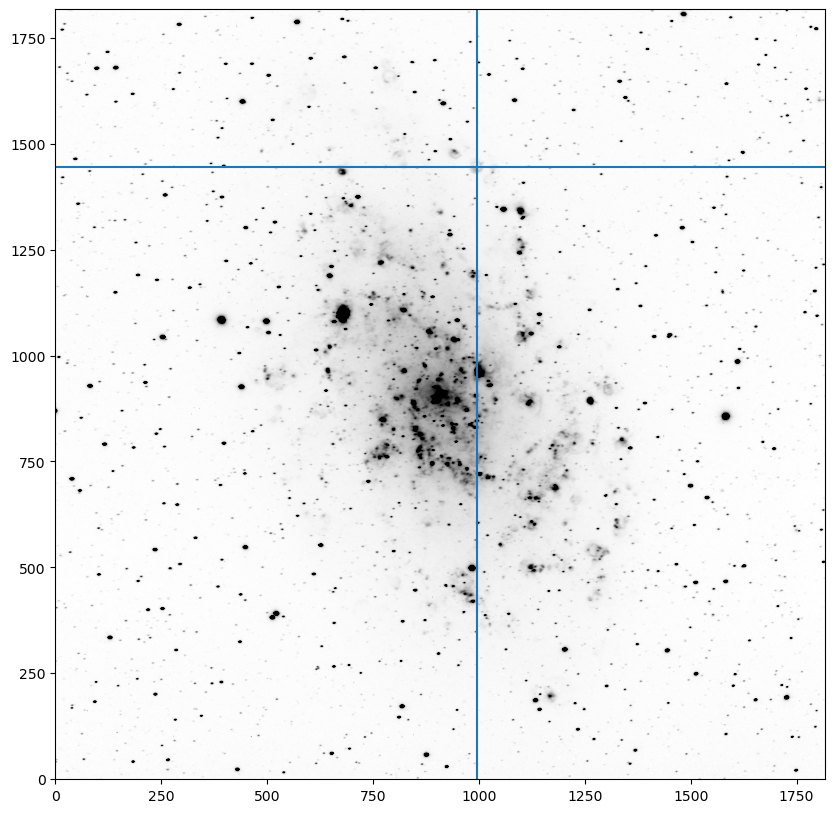

In [40]:
# Solution 
def crosshairs(ax,x,y):
    ax.axvline(x)
    ax.axhline(y) 
    return ax 

fig, ax = implot(m33_im,figsize=(10,10))
ax = crosshairs(ax,995,1445)

::::{admonition} Exercise 3.2 
:class: tip 

Now that we have a set of starting coordinates, we want to crop our image down to a certain window around our coordinates which contain the HII region. 

1. Write a function `crop_image` which takes in the image array, (x,y) central coordinates, and a window size in pixels. Your functiuon should compute the half-window size (integer division of input window by 2), then index the image from the central coordinates +/- the half-window size. It should return the new image. 
2. Use your `implot` function to show a new image output by your `crop_image` function using the above coordinates and a window size of 50 pixels.

:::{hint}
:class:dropdown
Remember that arrays are indexed by row first, then column! This means in our bracket indexing, "y-value" indexing comes first, then "x-value" indexing.

::::

(<Figure size 700x700 with 1 Axes>, <Axes: >)

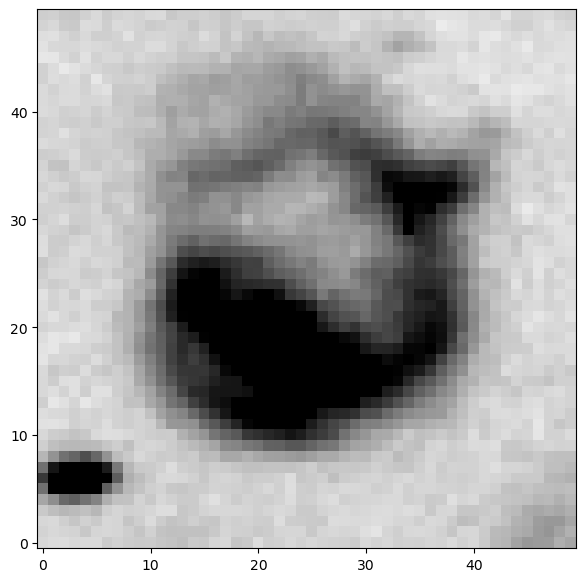

In [43]:
# Solution 

def crop_image(image,x,y,window_size): 
    half_window = int(window_size/2) 
    return image[y-half_window:y+half_window,x-half_window:x+half_window]

crop_test = crop_image(m33_im,995,1445,50)
implot(crop_test,percentiles=[1,95],figsize=(7,7))

::::{admonition} Exercise 3.3 
:class:tip 

You should hopefully now have a nice, circular feature filling most of your plotted image. This is our HII region! 

In order to estimate its radius in pixels, we'd like to place a circle down that lines up with the ridge of emission defining the circle (and adjust our center as needed, as our by-eye estimate from the full image was likely not perfect. 

1. Recall that we can compute the x and y values of a circle with position $(x_0,y_0)$ and radius $R$ via $x(\theta) = x_0 + R\cos(\theta)$ and $y(\theta) = y_0 + R\sin(\theta)$. Write a function `add_circle(ax,x,y,r)` which takes in our image `ax`, creates an array of `theta` values from 0 to $2\pi$ (Hint: `np.linspace()` is good for this), computes the arrays for the x and y positions of the circle based on its center and radius, plots them using `ax.plot(x,y)` over the image, and returns the ax.
2. Use your function to determine the new center and radius $R$ of this HII region.

:::{warning} 
When you crop from the full image to the zoom image, you have a new array with a new shape. Our original coordinates no longer matter; your $x,y$ center is the center of the *new* array, which should have a shape of 50x50. 

So starting with a center of 25,25 makes sense here. If you want to know what these coordinates refer to back in the original image, you'll have to do a coordinate transformation to "uncrop" them --- calculate the coordinates of the left and bottom edge of the crop region and add the new center in $x,y$ to those. 

We don't need to do that here, as we're interested in $R$ (which is preserved in the crop as the pixel scale has not changed), but not the precise $x$ or $y$ in original image coordinates.
:::
::::

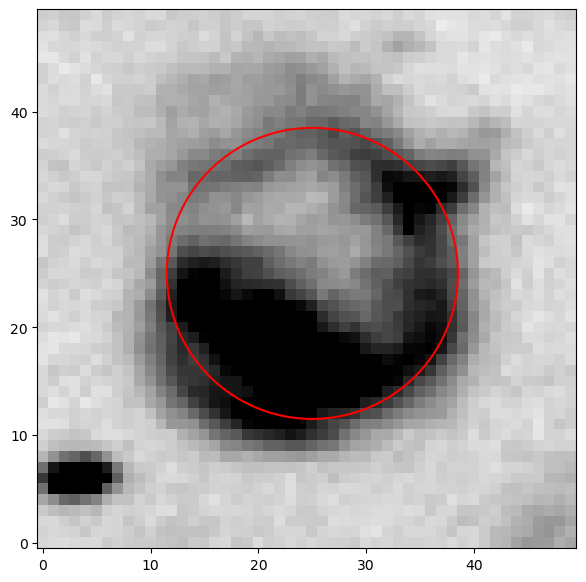

In [48]:
# Solution 

def add_circle(ax,x,y,r): 
    theta_arr = np.linspace(0,2*np.pi,200) 
    xx = x + r*np.cos(theta_arr) 
    yy = y + r*np.sin(theta_arr) 
    ax.plot(xx,yy,color='r')
    return ax 

fig, ax = implot(crop_test,percentiles=[1,95],figsize=(7,7))
ax = add_circle(ax,25,25,13.5)

:::{admonition} Exercise 3.4 
:class: tip
Now that we have a measurement of $R_{HII}$ in pixels, we need to begin converting this to a physical scale. We can do this because we know the *pixel scale* of our detector, that is, how many angular degrees (here we'll use the arcsecond) on sky does one pixel subtend. For example, if we have a pixel scale of 2.2, that means each pixel subtends 2.2 arcseconds on sky (roughly 0.0006 degrees). 

We can then make a triangle --- the long edge is the distance in physical units to M33. The short edge is the length we want, the physical radius of the HII region, and $\theta$ is our measured angular radius, obtained by multiplying the radius in pixels by the pixel scale. 


![triangle of distance and radius](distance_trigonometry.png)


To perform the actual trigonometric step, we need to compute $D\tan(\theta)$.

1. Write a function `compute_size(distance,s_pix,pixel_scale)`. Using the pixel scale, it should convert the size `s_pix` to arcseconds, then onward to degrees (there are 3600 arcseconds in a degree), then onward to radians for the trig function (`np.deg2rad()` may be useful here). Then, using that, compute the size using the formula above and return it. The size output will have units equal to the length units that were assumed for $D$. 

2. M33 has a distance of 0.869 Mpc (Megaparsec). Using your function, compute the radius of the HII region in parsec by converting the M33 distance to pc, then using your compute size function. Assume a pixel scale of 2.2. How big is this HII region?

In [51]:
#Solution 

def compute_size(distance,s_pix,pixel_scale): 
    theta_rad = np.deg2rad(s_pix*pixel_scale/3600)
    d = distance * np.tan(theta_rad) 
    return d 

r_HII = compute_size(869000,13.5,2.2)
print(f'The HII region has a size of {r_HII:.2f} pc')

The HII region has a size of 125.13 pc


:::{admonition} Exercise 3.5 (Bonus) 
:class: tip 

We can avoid the annoyance of unit conversions by using the `astropy.units` library. Look up how to create astropy unit quantities, and rewrite your `compute_size` function to allow distance to be input in any unit, as well as the pixel scale. Then easily convert your output to `pc` at the end and return it. 
:::

In [54]:
# Solution 
import astropy.units as u
def compute_size_units(distance,s_pix,pixel_scale): 
    d = distance * np.tan(s_pix*pixel_scale) 
    return d.to(u.pc)


r_HII = compute_size_units(0.869*u.Mpc,13.5,2.2*u.arcsec)
print(f'The HII region has a size of {r_HII:.2f} pc')

The HII region has a size of 125.13 pc pc


:::{admonition} Exercise 3.6 
:class:tip 

Now that we know the physical size of the HII region (not a trivial feat!) we can actually go further. In a back-of-the-envelope sense, the radius of the full HII region can be approximated as that of a Strömgren sphere around a "single" high energy star. 

The formula for this radius is 

$$
r_S = \left(\frac{3N^*}{4\pi\alpha n^2}\right)^\frac{1}{3}
$$
where $N^*$ is the ionizing photon rate from the OB star (typically $\sim 10^{49}$ photon s$^{-1}$), $\alpha \sim 3\times10^{-13}$ cm$^{3}$ s$^{-1}$ is the recombination coefficient, and $n\sim 10$ cm$^{-3}$ is the number density. 

We *know* $r_S$. Solve this equation instead for $N^*$, writing a function that returns the value of

$$
\left(\frac{N^*}{10^{49}}\right)
$$

Having done so, you now have a function that given a radius and assumptions about particle density and recombination coefficient returns the "number" of OB stars driving the HII region! (Technically, we have an answer that is units of the typical OB star's photon flux, so the actual number of stars could be lower if each is more massive and brighter and vice versa --- but this gives both the actual driving flux and an approximate order-of-magnitude estimate for the number of stars. 

Play with your function a bit, putting in values from 10 pc to 500 pc for the size, and see how the ionizing flux changes!
:::

:::{admonition} Exercise 3.7: Putting it all together 
:class: tip 
Throughout the course of this lab, you have written several shorter (and longer) functions. For our `implot` function, it is hopefully clear why having that function around is handy --- to set everything we included every time we wanted to quickly view some fits file or local array would be onerous; this function now makes it very easy to get a useful result in a simple one line call, with plenty of room to specify options if we desire. 


On the other hand, something we covered in lecture was that functions are most useful for *reusable* bits of code. Thus far, though, we only measured one HII region. In theory, all of the computations we did along the way could have been done directly in our script or notebook and it would not have been that disorganized of a file. 


Let's now demonstrate why writing functions *was* useful, even for the small steps. 

1. Using the original image, pick **four more** HII regions in the image of M33, and determine their physical sizes and number of OB stars.

Tasked with this, hopefully you will be able to re-use your defined functions to make locating and measuring the size of each much easier! Create section headings in your solution with each one. While the solution won't be fully automatic, since we still have some by-eye assesment happening, the final code block for doing this whole measurement will only be a few lines long, calling our pre-made functions. As we move further into the semester, we will learn how to automate, e.g., finding the locations of features of interest and measuring the size of those features. 

:::